# PBO learnt on several iterations and one weigth one the chain walk environment

## Define parameters

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax

# keys
seed = 1
key = jax.random.PRNGKey(seed)
env_key, key = jax.random.split(key)
shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 4)

# Box over states and actions
n_states = 100
n_actions = 2
n_repetitions = 10
sucess_probability = 0.9
gamma = 0.99

# Weights collection
n_weights = 1
filtering_weights = True

# PBO trainings
max_bellman_iterations = 200
add_infinity = False

## Linear PBO
max_steps = 10
batch_size_samples = n_states // 2
batch_size_weights = n_weights
learning_rate = {"first": 0.001, "last": 0.001, "duration": max_steps}

## Q-learning
learning_rate_q = {"first": 1, "last": 1, "duration": max_steps}

# Visualisation
plot_freq = 5
sleeping_time = 0

## Define environment

In [2]:
from pbo.environment.chain_walk import ChainWalkEnv

states = np.arange(n_states)
actions = np.arange(n_actions)
states_boxes = (np.arange(n_states + 1 + 1) - 0.5)[:-1]
actions_boxes = (np.arange(n_actions + 1 + 1) - 0.5)[:-1]

env = ChainWalkEnv(env_key, n_states, sucess_probability, gamma)

## Collect samples

### Samples on the mesh

In [3]:
import jax.numpy as jnp

from pbo.sample_collection.replay_buffer import ReplayBuffer


n_samples = n_states * n_actions * n_repetitions
replay_buffer = ReplayBuffer()

for state in states:
    for action in actions:
        # Need to repeat the samples to capture the randomness
        for _ in range(n_repetitions):
            env.reset(jnp.array([state]))
            next_state, reward, _, _ = env.step(jnp.array([action]))

            replay_buffer.add(jnp.array([state]), jnp.array([action]), reward, next_state)

replay_buffer.cast_to_jax_array()

### Visualize samples

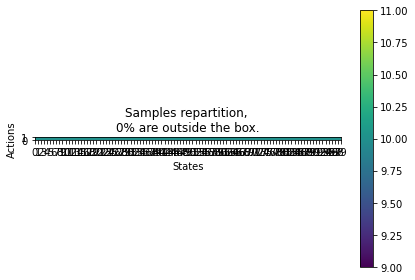

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.state_action_mesh import StateActionMesh


samples_count, n_outside_boxes = count_samples(replay_buffer, states_boxes, actions_boxes)
samples_visu_mesh = StateActionMesh(states, actions, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)

## Optimal Q function

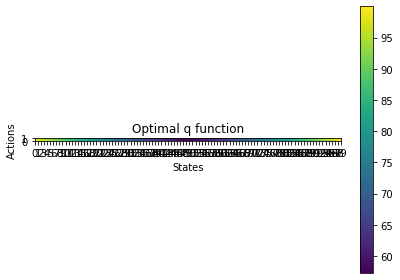

In [5]:
optimal_q = env.optimal_Q_mesh()

q_visu_mesh = StateActionMesh(states, actions, sleeping_time)

q_visu_mesh.set_values(optimal_q)
q_visu_mesh.show("Optimal q function")

## Build q network

In [6]:
from pbo.networks.learnable_q import TableQ


q = TableQ(
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    n_states=n_states,
    n_actions=n_actions
)

## Collect weights

In [7]:
from pbo.weights_collection.weights_buffer import WeightsBuffer


weights_buffer = WeightsBuffer()

while len(weights_buffer) < n_weights:
    weights = q.random_init_weights()
    if not filtering_weights or weights.max() < 1 / (1 - gamma):
        weights_buffer.add(weights)

weights_buffer.cast_to_jax_array()

## The performance is a function of the training losses

In [8]:
# from pbo.utils.shared_axis_plot import shared_axis_plot


# # For visualization
# full_batch = {
#     "state": replay_buffer.states,
#     "action": replay_buffer.actions,
#     "reward": replay_buffer.rewards,
#     "next_state": replay_buffer.next_states,
# }
# l1_losses = []
# contraction = []

# step = 0
# l1_loss = float("inf")

# while l1_loss > tolerance and step < max_steps:
#     cumulative_l2_loss = 0
#     importance_iteration = jnp.ones(max_bellman_iterations + 1)
#     importance_iteration = importance_iteration.at[-1].set(0)
    
#     data_loader_weights.shuffle()
#     for batch_weights in data_loader_weights:
#         data_loader_samples.shuffle()
#         for batch_samples in data_loader_samples:
#             pbo.params, pbo.optimizer_state, l2_loss = pbo.learn_on_batch(pbo.params, pbo.optimizer_state, batch_weights, batch_samples, importance_iteration)            
#             cumulative_l2_loss += l2_loss

#     # Visualization
#     if step % plot_freq == 0:
#         l1_losses_iteration = np.zeros(max_bellman_iterations + 3)
#         batch_iterated_weights = data_loader_weights.weights.copy()

#         for iteration in range(max_bellman_iterations):
#             batch_targets = pbo.compute_target(batch_iterated_weights, full_batch)
#             batch_iterated_weights = pbo(pbo.params, batch_iterated_weights)
#             q_values = jax.vmap(lambda weights: pbo.q(pbo.q.to_params(weights), full_batch["state"], full_batch["action"]))(
#                 batch_iterated_weights
#             )

#             l1_losses_iteration[iteration] = jnp.abs(q_values - batch_targets).mean()

#         fixed_point = pbo.fixed_point(pbo.params).reshape((1, -1))
#         batch_targets_inf = pbo.compute_target(fixed_point, full_batch).reshape(
#             (-1, n_states, n_actions)
#         )

#         q_values_inf = jax.vmap(lambda weights: pbo.q(pbo.q.to_params(weights), full_batch["state"], full_batch["action"]))(
#             fixed_point
#         ).reshape((-1, n_states, n_actions))
        
#         l1_losses_iteration[-3] = jnp.abs(q_values_inf - batch_targets_inf).mean()
#         l1_losses_iteration[-2] = jnp.abs(optimal_q - q_values.reshape((-1, n_states, n_actions))).mean()
#         l1_losses_iteration[-1] = jnp.abs(optimal_q - q.to_params(pbo.fixed_point(pbo.params))["TableQNet"]["table"]).mean()

#         l1_losses.append(l1_losses_iteration)
#         contraction.append(pbo.contracting_factor())

#         l1_loss = pbo.loss(pbo.params, data_loader_weights.weights, full_batch, importance_iteration, ord=1)


#     step += 1

# print(f"Tolerance not achieved: {l1_loss}") if step == max_steps else print("Tolerance achieved")
# shared_axis_plot(contraction, np.array(contraction) * np.nan, f"every {plot_freq} steps", "contraction factor")

In [9]:
# import matplotlib.pyplot as plt 

# l1_losses_array = np.array(l1_losses)

# for iteration in np.arange(max_bellman_iterations):
#     plt.plot(l1_losses_array[:, iteration], label=f"Iteration {iteration + 1}")

# plt.plot(l1_losses_array[:, -3], label=f"Iteration inf")
# plt.plot(l1_losses_array[:, -2], label=f"Q* - Q^MaxBellmanIteration", linestyle="--")
# plt.plot(l1_losses_array[:, -1], label=f"Q* - Q^fixed_point", linestyle="--")

# plt.xlabel(f"every {plot_freq} steps")
# plt.yscale("log")
# plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
# plt.title("Errors over the training steps")
# plt.show()

In [10]:
# _ = plt.plot(range(max_bellman_iterations), l1_losses_array[-1, :-3])

## The last iterations matter most 

In [11]:
# from tqdm.notebook import tqdm

# from pbo.sample_collection.dataloader import SampleDataLoader
# from pbo.weights_collection.dataloader import WeightsDataLoader
# from pbo.networks.learnable_pbo import LinearPBO


# data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
# data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
# pbo = LinearPBO(q, max_bellman_iterations, gamma, add_infinity, pbo_network_key, learning_rate)

# # For visualization
# full_batch = {
#     "state": replay_buffer.states,
#     "action": replay_buffer.actions,
#     "reward": replay_buffer.rewards,
#     "next_state": replay_buffer.next_states,
# }

# training_losses_uniform = []
# validation_losses_uniform = []

# for k in tqdm(np.arange(max_bellman_iterations)):
#     importance_iteration = jnp.zeros(max_bellman_iterations + 1)
#     importance_iteration = importance_iteration.at[k].set(1)

#     params_target = pbo.params

#     for step in range(max_steps):
#         for batch_weights in data_loader_weights:
#             data_loader_samples.shuffle()
#             for batch_samples in data_loader_samples:
#                 pbo.params, pbo.optimizer_state, _ = pbo.learn_on_batch(pbo.params, params_target, pbo.optimizer_state, batch_weights, batch_samples, importance_iteration)            

#     batch_iterated_weights = data_loader_weights.weights.copy()
#     for _ in range(k):
#         batch_iterated_weights = pbo(pbo.params, batch_iterated_weights)

#     training_losses_uniform.append(pbo.loss(pbo.params, params_target, data_loader_weights.weights, full_batch, importance_iteration, ord=1))
#     validation_losses_uniform.append(jnp.abs(optimal_q.flatten() - q.discretize(batch_iterated_weights, states, actions).flatten()).mean())

In [12]:
# from tqdm.notebook import tqdm


# data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
# data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
# pbo = LinearPBO(q, max_bellman_iterations, gamma, add_infinity, pbo_network_key, learning_rate)

# # For visualization
# full_batch = {
#     "state": replay_buffer.states,
#     "action": replay_buffer.actions,
#     "reward": replay_buffer.rewards,
#     "next_state": replay_buffer.next_states,
# }

# training_losses_geom = []
# validation_losses_geom = []
# c_steps = max_steps * max_bellman_iterations / (np.sum([k for k in range(1, max_bellman_iterations + 1)])) 

# for k in tqdm(np.arange(max_bellman_iterations)):
#     importance_iteration = jnp.zeros(max_bellman_iterations + 1)
#     importance_iteration = importance_iteration.at[k].set(1)

#     params_target = pbo.params

#     n_steps = np.maximum(int(np.round(c_steps * (k + 1))), 1)

#     for step in range(n_steps):
#         for batch_weights in data_loader_weights:
#             data_loader_samples.shuffle()
#             for batch_samples in data_loader_samples:
#                 pbo.params, pbo.optimizer_state, _ = pbo.learn_on_batch(pbo.params, params_target, pbo.optimizer_state, batch_weights, batch_samples, importance_iteration)            
                
#     batch_iterated_weights = data_loader_weights.weights.copy()
#     for _ in range(k):
#         batch_iterated_weights = pbo(pbo.params, batch_iterated_weights)

#     training_losses_geom.append(pbo.loss(pbo.params, params_target, data_loader_weights.weights, full_batch, importance_iteration, ord=1))
#     validation_losses_geom.append(jnp.abs(optimal_q.flatten() - q.discretize(batch_iterated_weights, states, actions).flatten()).mean())

In [13]:
# import matplotlib.pyplot as plt 

# plt.plot(validation_losses_uniform, label="uniform")
# plt.plot(validation_losses_geom, label="geom")

# plt.legend()


In [14]:
# plt.plot([c_steps * k for k in range(1, max_bellman_iterations + 1)])
# plt.plot(np.ones(max_bellman_iterations) * max_steps)

In [15]:
# plt.plot(training_losses_uniform, label="uniform")
# plt.plot(training_losses_geom, label="geom")

# plt.legend()

## Fitted-Q

In [16]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_pbo import LinearPBO


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
pbo = LinearPBO(q, max_bellman_iterations, add_infinity, pbo_network_key, learning_rate)
q = TableQ(
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    n_states=n_states,
    n_actions=n_actions,
    learning_rate=learning_rate_q,
)

weight = weights_buffer.weights[0]

# For visualization
full_batch = {
    "state": replay_buffer.states,
    "action": replay_buffer.actions,
    "reward": replay_buffer.rewards,
    "next_state": replay_buffer.next_states,
}

training_losses_q_uniform = []
validation_losses_q_uniform = []

for k in tqdm(np.arange(max_bellman_iterations)):
    params_target = q.params

    if (k + 1) % 10 == 0 or k == 0:
        data_loader_samples.shuffle()

    for step in range(max_steps):
        for batch_samples in data_loader_samples:
            q.params, q.optimizer_state, _ = q.learn_on_batch(q.params, params_target, q.optimizer_state, batch_samples)
            break          

    training_losses_q_uniform.append(q.loss(q.params, params_target, full_batch, ord=1))
    validation_losses_q_uniform.append(jnp.abs(optimal_q.flatten() - q.discretize(q.to_weights(q.params).reshape((-1, q.weights_dimension)), states, actions).flatten()).mean())

  0%|          | 0/200 [00:00<?, ?it/s]

In [17]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_pbo import LinearPBO


data_loader_samples = SampleDataLoader(replay_buffer, n_samples, shuffle_key)
pbo = LinearPBO(q, max_bellman_iterations, add_infinity, pbo_network_key, learning_rate)
q = TableQ(
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    n_states=n_states,
    n_actions=n_actions,
    learning_rate=learning_rate_q,
)

weight = weights_buffer.weights[0]

# For visualization
full_batch = {
    "state": replay_buffer.states,
    "action": replay_buffer.actions,
    "reward": replay_buffer.rewards,
    "next_state": replay_buffer.next_states,
}

training_losses_q_geom = []
validation_losses_q_geom = []
c_samples = batch_size_samples * max_bellman_iterations / (np.sum([k for k in range(1, max_bellman_iterations + 1)])) 


for k in tqdm(np.arange(max_bellman_iterations)):
    params_target = q.params

    if (k + 1) % 10 == 0 or k == 0:
        data_loader_samples.shuffle()
    n_samples_iteration = np.maximum(int(np.round(c_samples * (k + 1))), 1)

    for step in range(max_steps):
        batch_samples = {
            "state": data_loader_samples[0]["state"][: n_samples_iteration],
            "action": data_loader_samples[0]["action"][: n_samples_iteration],
            "reward": data_loader_samples[0]["reward"][: n_samples_iteration],
            "next_state": data_loader_samples[0]["next_state"][: n_samples_iteration],
        }
        q.params, q.optimizer_state, _ = q.learn_on_batch(q.params, params_target, q.optimizer_state, batch_samples)            

    training_losses_q_geom.append(q.loss(q.params, params_target, full_batch, ord=1))
    validation_losses_q_geom.append(jnp.abs(optimal_q.flatten() - q.discretize(q.to_weights(q.params).reshape((-1, q.weights_dimension)), states, actions).flatten()).mean())

  0%|          | 0/200 [00:00<?, ?it/s]

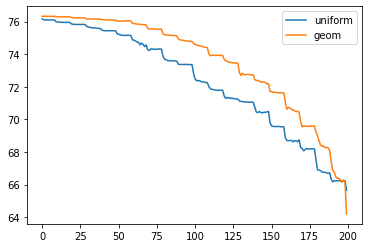

In [18]:
import matplotlib.pyplot as plt 

plt.plot(validation_losses_q_uniform, label="uniform")
plt.plot(validation_losses_q_geom, label="geom")

plt.legend()

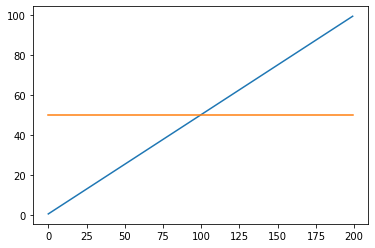

In [19]:
plt.plot([c_samples * k for k in range(1, max_bellman_iterations + 1)])
plt.plot(np.ones(max_bellman_iterations) * batch_size_samples)

## Train PBO over different K

In [20]:
# from tqdm import tqdm


# ks = np.arange(max_bellman_iterations, step=3)
# training_losses = np.zeros((2,len(ks)))
# validation_losses = np.zeros((2, len(ks)))

# uniform_importance = jnp.ones(max_bellman_iterations + 1)
# uniform_importance = uniform_importance.at[-1].set(0)
# linear_importance = jnp.linspace(max_bellman_iterations + 1, 1, max_bellman_iterations + 1)
# linear_importance = linear_importance.at[-1].set(0)
# list_importance_iteration = [uniform_importance, linear_importance]

# for idx_importance, importance_iteration in enumerate(list_importance_iteration):
#     for idx_k, k in tqdm(enumerate(np.arange(max_bellman_iterations, step=3)), leave=False):
#         # Define PBO and dataloaders
#         data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
#         data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)

#         pbo = LinearPBO(q, k, gamma, pbo_network_key, learning_rate)

#         # Learn the PBO
#         for step in range(500):
#             cumulative_l2_loss = 0
            
#             data_loader_weights.shuffle()
#             for batch_weights in data_loader_weights:
#                 data_loader_samples.shuffle()
#                 for batch_samples in data_loader_samples:
#                     pbo.params, pbo.optimizer_state, l2_loss = pbo.learn_on_batch(pbo.params, pbo.optimizer_state, batch_weights, batch_samples, importance_iteration.at[k + 1].set(0))            
#                     cumulative_l2_loss += l2_loss

#             step += 1

#         training_losses[idx_importance, idx_k] = pbo.loss(pbo.params, data_loader_weights.weights, full_batch, importance_iteration.at[k + 1].set(0), ord=1)
        
#         batch_iterated_weights = data_loader_weights.weights.copy()
#         for _ in range(k):
#             batch_iterated_weights = pbo(pbo.params, batch_iterated_weights)
        
#         validation_losses[idx_importance, idx_k] = jnp.abs(optimal_q.flatten() - q.discretize(batch_iterated_weights, states, actions).flatten()).mean()

In [21]:
# import matplotlib.pyplot as plt 

# plt.plot(ks, validation_losses[0], label="Uniform")
# plt.plot(ks, validation_losses[1], label="Linear increasing")
# plt.xticks(ks)
# plt.legend()

# _ = plt.show()

In [22]:
# plt.plot(ks, validation_losses[0], label="Validation Uniform")
# plt.plot(ks, validation_losses[1], label="Validation Linear increasing")
# plt.plot(ks, training_losses[0], label="Training Uniform", linestyle="--")
# plt.plot(ks, training_losses[1], label="Training Linear increasing", linestyle="--")
# plt.xticks(ks)
# plt.yscale("log")
# plt.legend()

# _ = plt.show()